<a href="https://colab.research.google.com/github/effepivi/gvxr-tutorials/blob/main/Detector_parameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

# Session 5

## Detector Parameters ![gVXR](img/gvxr_logo.png)

## Authors: Iwan Mitchell

(version 1.1, 7 Mar 2023)

## Aims of this session
- Introduction to more advanced detector properties
- Learn the effect of magnification on tube-based scanners
- See how the detector's Line Spread Function dramatically change result quality (pixels are not everything!)

In [1]:
import os
from gvxrPython3 import gvxr, json2gvxr
import matplotlib.pyplot as plt
import matplotlib.ticker as plttick
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
from math import e, pi, sqrt
from scipy.signal import unit_impulse

SimpleGVXR 2.0.4 (2023-03-06T19:28:30) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 2.0.4 (2023-03-06T19:28:30) [Compiler: GNU g++] on Linux


Download the Sample if needed

In [3]:
# The directory does not exist
if not os.path.exists("input_data"):
    
    # Create the directory
    os.mkdir("input_data")

# # The directory does not exist
# if not os.path.exists("input_data/TurboPump"):
    
#     # Create the directory
#     os.mkdir("input_data/TurboPump")

files = ["notebook5-detector-lsf.json", "notebook5-multimat-spheres.json"]
for fname in files:
    if not os.path.exists(fname):
        print("Download the file (%s)" % fname)
        import urllib.request
        url = "https://github.com/effepivi/gvxr-tutorials/raw/main/" + fname
        urllib.request.urlretrieve(url, fname)

In [4]:
# Load in gvxr parameters from a json file
json2gvxr.initGVXR("./notebook5-detector-lsf.json", "EGL")
json2gvxr.initDetector()
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum()
json2gvxr.initSamples()

# Remove the current LSF
gvxr.setLSF((0,1,0))

Create an OpenGL context: 800x450
Set up the detector
	Detector position: [0, 10, 0, 'cm']
	Detector up vector: [0, 0, 1]
	Number of pixels: [300, 320]
	Detector number of pixels: [300, 320]
	Pixel spacing: [0.5, 0.5, 'mm']
LSF: [0.00110698, 0.00122599, 0.00136522, 0.00152954, 0.00172533, 0.00196116, 0.0022487, 0.00260419, 0.00305074, 0.00362216, 0.00436939, 0.00537209, 0.00676012, 0.0087564, 0.01176824, 0.01659933, 0.02499446, 0.04120158, 0.0767488, 0.15911699, 0.24774516, 0.15911699, 0.0767488, 0.04120158, 0.02499446, 0.01659933, 0.01176824, 0.0087564, 0.00676012, 0.00537209, 0.00436939, 0.00362216, 0.00305074, 0.00260419, 0.0022487, 0.00196116, 0.00172533, 0.00152954, 0.00136522, 0.00122599, 0.00110698]
Set up the beam
	Source position: [0, -40, 0, 'cm']
	Source shape: Parallel


Tue Mar  7 17:15:25 2023 ---- Create window (ID: -1)
Tue Mar  7 17:15:25 2023 ---- Query the number of EGL devices
Tue Mar  7 17:15:25 2023 ---- Success
Tue Mar  7 17:15:25 2023 ---- Detected 3 EGL devices.
Tue Mar  7 17:15:25 2023 ---- Print the details here of every EGL device.
Tue Mar  7 17:15:25 2023 ---- Success
Tue Mar  7 17:15:25 2023 ---- Device 1/3:
Tue Mar  7 17:15:25 2023 ---- 	Device Extensions: EGL_NV_device_cuda EGL_EXT_device_drm EGL_EXT_device_drm_render_node EGL_EXT_device_query_name EGL_EXT_device_persistent_id
Tue Mar  7 17:15:25 2023 ---- 	Device vendor: NVIDIA
Tue Mar  7 17:15:25 2023 ---- 	EGL DRM device file: /dev/dri/card0
Tue Mar  7 17:15:25 2023 ---- Device 2/3:
Tue Mar  7 17:15:25 2023 ---- 	Device Extensions: EGL_EXT_device_drm
Tue Mar  7 17:15:25 2023 ---- 	Failed to retrieve device vendor.
Tue Mar  7 17:15:25 2023 ---- 	EGL DRM device file: /dev/dri/card0
Tue Mar  7 17:15:25 2023 ---- Device 3/3:
Tue Mar  7 17:15:25 2023 ---- 	Device Extensions: EGL_MESA_d

# Introduction to the Detector
The Detector is a core component of all scanning systems. It is the part receiving X-rays from the beam source, converting them into signals (the images we see).

In a previous setting you quickly looked at defining a detector's spacial location, along with the number and size of pixels the detector will receive. In this notebook, we will take a further in-depth look into how these parameters are not enough to accurately simulate real-life detectors.

In gVXR, the detector is modelled as a simple 2D plane in the path of the beam source. This virtual detector by default has perfect properties, resulting in a theoretical perfect image. Real life detectors are unfortunately not perfect, and obtaining high quality images relies on more than resolution.

![](img/scene-detector.drawio.png)


Just like a camera, detectors can be built in many different ways. One common detector type uses scintillators to absorb x-rays and re-emit the absorbed energy as light. This light is then detected using transistors to produce an electrical image.

![](img/detector-scintillator.drawio.png)

Keep in mind that this process isn't perfect! the generated light energy is picked up by neighboring transistors, causing blurring. Depending on the quality of the detector, this can drastically affect the quality of the produced scan. This phenomenon can be measured and used to calibrate detectors. The measured response is called the Line Spread Function.


## Resolution and Pixel Size

Detectors come in many different sizes, and are represented in different formats.
gVXR only supports denoting detector sizes using pixel size, and resolution.

Sometimes, the term *pixel pitch* is used. Pixel pitch is the distance between the centre of two pixels. It is often assumed that the edge of pixels have no width;- resulting in a pixel size equal to the pixel pitch.

![](img/detector-size.drawio.png)

### Task: Setting Pixel Size and Resolution

Setting the detector size in gVXR is easy, but it only supports pixel values. 
That is, the physical width of the simulated detector is equal to the detector's pixel width multiplied by the number of horizontal pixels and similar for calculating physical height.
The detector's resolution *must* be in pixels, you will have to convert the values yourself.

In [5]:
# Set resolution to 512x512 with a pixel size of 200μm
gvxr.setDetectorNumberOfPixels(512, 512)
gvxr.setDetectorPixelSize(200, 200, "um")

# Create a detector with a width of 8.192mm, height of 12.046mm and with a pixel size of 8μm
gvxr.setDetectorPixelSize(8, 8, "um")
gvxr.setDetectorNumberOfPixels(1024, 1506)

# Using a resolution of 500x1000, create a detector with a width of 10mm and height of 20mm
gvxr.setDetectorNumberOfPixels(500, 1000)
gvxr.setDetectorPixelSize(20,20,"um")

# Create a detector with a resolution of 512x512 with a pixel pitch of 20μm
gvxr.setDetectorNumberOfPixels(512, 512)
gvxr.setDetectorPixelSize(20,20,"um")

Tue Mar  7 17:15:32 2023 ---- Initialise the renderer
Tue Mar  7 17:15:32 2023 ---- Initialise the renderer
Tue Mar  7 17:15:32 2023 ---- Initialise the renderer
Tue Mar  7 17:15:32 2023 ---- Initialise the renderer


### Task: Pixel Binning

Pixel binning is a method to reduce noise by combining values from multiple pixels and resulting in a lower resolution image.
The result may have less total resolution, but the overall noise is decreased as more samples per pixel are used.

![](img/detector-stride.drawio.png)

gVXR does not directly support detector binning, however there are two approaches to recreate this detector feature:
1. Double the pixel size to directly reduce the resolution
2. Sample a full-resolution image

Method 2. can be done using [scikit-learn's `downscale_local_mean`](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.downscale_local_mean) but that will not be covered in this lesson.

In [6]:
# Approach 1 - Doubling pixel size

# Create a detector with a width of 100cm, height of 120cm and with a pixel size of 80μm
gvxr.setDetectorPixelSize(80,80,"um")
gvxr.setDetectorNumberOfPixels(1250,1500)

refImg = gvxr.computeXRayImage()

# Create the same detector, but with a pixel size of 160μm to recreate a binned pixel
gvxr.setDetectorPixelSize(160,160,"um")
gvxr.setDetectorNumberOfPixels(625, 750)

newImg = gvxr.computeXRayImage()

# -----
# Make a simple side-by-side with matplotlib
fig, axes = plt.subplots(1,2)
axes[0].imshow(refImg,cmap="gray")
axes[1].imshow(newImg,cmap="gray")

Tue Mar  7 17:15:33 2023 ---- Initialise the renderer
Tue Mar  7 17:15:33 2023 ---- Initialise the renderer


Here we can see that the physical pane size has not changed, but the resolution is halved.

## OTF, MTF, PSF, ESF, and LSF

OTF, MTF, PSF, and LSF are all values used to represent the 'spillover' caused by imperfect detectors. Since scintillator detectors are not perfect there is light leakage causing other nearby pixels to be effected. This has a dramatic effect on scans. Although the large number of acronyms can be confusing, we are only interested in LSF and PSF.

The Optical Transfer Function (OTF) specifies how the detector system reacts to different spacial frequencies. It describes in the Fourier domain the transform of the Point Spread Function (PSF) applied to an image received by the detector. The Modulation Transfer Function (MTF) is defined as the magnitude of the OTF and has similar uses in different fields.

![OTF relationship](img/otf.drawio.png)

**In our specific case, we are only interested in the Point Spread Function (PSF) and Line Spread Function (LSF).**
The PSF can be seen as the effect a single pixel has on the surrounding pixels, whereas LSF is a single line of this PSF though the origin. As mentioned previously in this notebook, a detector's construction is not perfect, and the scintillators commonly used in detectors are picked up by neighboring pixels.

![](img/detector-scintillator.drawio.png)

LSF is used rather than PSF as the measurement can be calculated from an image by using a sharp gradient change, and calculating the Edge Spread Function (ESF). The first derivative of the ESF is the LSF.
Although it would be more mathematically correct to use the PSF; this cannot be calculated using experiments, as the original obtained LSF is already been affected by the vertical component of the PSF.
This is regarded as generally a non-issue, since the common usage of xCT is to assume slices are independent of each other.

If the above explanation has confused you, don't worry. The key influencing factor on scans is the Line Spread Function, as it is responsible for blurring in images.

![Detector LSF](img/detector-lsf.png)

Shown below are two images; one of a Siemens Star with no LSF applied, and another with a LSF calibrated from a physical detector

| Perfect Detector | Real Detector |
| --- | --- |
| ![](img/siemens-perfect.png) | ![](img/siemens-real.png) |

Notice how even with the same detector parameters, the image is heavily blurred.
Another example with the same setup, but taken as a CT acquisition and reconstruction:

| Plate CT Perfect Detector | Plate CT Real Detector |
| --- | --- |
| ![](img/plate-recon-perfect.png) | ![](img/plate-recon-real.png) |

<small>(Reconstructed using 360 projections with FDK)</small>

### LSF Playground

Now that you know what the LSF is, this is a small demo where you can adjust the 'Spikiness' of an LSF function.

Use the slider to adjust the peak size, and click simulate to generate a quick projection. Feel free to look at the code and see how it works!

In [6]:
# Load in gvxr parameters from a json file
gvxr.clearDetectorEnergyResponse()
json2gvxr.initGVXR("./notebook5-detector-lsf.json")
json2gvxr.initDetector()
json2gvxr.initSourceGeometry()
json2gvxr.initSpectrum()
json2gvxr.initSamples()


# Widgets
slider = widgets.FloatSlider(value=0.9,min=0.1,max=0.90,step=0.01,description="LSF Peak",readout=True)
button = widgets.Button(description="Simulate")
color = widgets.Checkbox(description="Grayscale")
output = widgets.Output(layout=widgets.Layout(height='600px'))

# Simulate LSF
def simulate_lsf(b):
    with output:
        # Create a Dirac (Our man-made LSF function)
        a = slider.value * -1 + 1
        x = np.linspace(-2,2,41)
        lsf = ((1 / abs(a) * sqrt(pi)) * e) ** (((x / a) ** 2) * -1)
        lsf /= np.sum(lsf)

        # Simulate Projection
        gvxr.setLSF(lsf)
        image = gvxr.computeXRayImage()

        # Plot LSF
        output.clear_output()
        fig, axes = plt.subplots(1,2)
        axes[0].set_title("Detector LSF")
        axes[0].set_xlabel("Pixel")
        axes[0].set_ylabel("Pixel Contribution")
        axes[0].set_ybound(0,1)
        axes[0].set_xbound(-20,20)
        axes[0].set_autoscale_on(False)
        axes[0].plot(np.linspace(-20,20,41), lsf)
        cmap = "gray" if color.value else None
        axes[1].imshow(image,cmap=cmap)
        plt.show()

# Bind and display
button.on_click(simulate_lsf)
display(output)
display(widgets.HBox((button,slider,color)))
simulate_lsf(None)

Create an OpenGL context: 800x450
Set up the detector
	Detector position: [0, 10, 0, 'cm']
	Detector up vector: [0, 0, 1]
	Number of pixels: [300, 320]
	Detector number of pixels: [300, 320]
	Pixel spacing: [0.5, 0.5, 'mm']
LSF: [0.00110698, 0.00122599, 0.00136522, 0.00152954, 0.00172533, 0.00196116, 0.0022487, 0.00260419, 0.00305074, 0.00362216, 0.00436939, 0.00537209, 0.00676012, 0.0087564, 0.01176824, 0.01659933, 0.02499446, 0.04120158, 0.0767488, 0.15911699, 0.24774516, 0.15911699, 0.0767488, 0.04120158, 0.02499446, 0.01659933, 0.01176824, 0.0087564, 0.00676012, 0.00537209, 0.00436939, 0.00362216, 0.00305074, 0.00260419, 0.0022487, 0.00196116, 0.00172533, 0.00152954, 0.00136522, 0.00122599, 0.00110698]
Set up the beam
	Source position: [0, -40, 0, 'cm']
	Source shape: Parallel


Tue Mar  7 17:11:24 2023 ---- Initialise the renderer
Tue Mar  7 17:11:24 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/input_data/phantoms/star.stl	nb_faces:	160	nb_vertices:	480	bounding_box (in cm):	(-3.99994, -3.99994, -0.499992)	(3.99994, 3.99994, 0.499992)


Output(layout=Layout(height='600px'))

## Flatfield Correction

So far, apart from scintillator parameters, we've been assuming the detector itself is mostly perfect. In the real case, this is incorrect.
The detector can build up defects over time, such as dust, and the beam itself is not a uniform spread of intensity across the detector.
Flatfield Correction is an approach to remove this fixed-pattern noise, and reduce image quality loss.

| Raw Image | Flatfield-Corrected Image |
| --- | --- |
| ![](img/flatfield-before.png) | ![](img/flatfield-after.png) |

In order to overcome this, scanners use flatfields as a way to calibrate and correct scanners to ensure a high quality image.
A lightfield is a scan image with no sample in place, and represents the maximum beam intensity for each pixel.
This lightfield is then used with a darkfield;- an image where the beam is off and represents the minimum intensity of each pixel.

$$ corrected = \frac{raw - darkfield}{lightfield - darkfield} $$


Below is the lightfield of our simulated scanner;- it is a uniform white image as every pixel receives the same beam intensity.
Next to it is a lightfield from a beamline at the Diamond Light Source taken from a recent experiment.

|Ideal Lightfield (Uniform White Image) | Real Lightfield |
| --- | --- |
| ![](img/lightfield-simulated.png)|![](img/lightfield-diamond.png)|

In industrial machines this process is automatic, and result images have already been normalized. In more specialized scenarios such as synchrotrons and some lab systems, this has to be done manually. In simulations, the detector lacks any fixed-pattern noise, however we still need to account for the beam's photon count.

*Note: flatfield correction still has to be done in order to balance out photon energy, even if no fixed-pattern noise is present!*


# Energy Response

Another often overlooked property of a detector is its response to different energies. This is because most detectors use a scintillator, which converts x-rays into light. This behavior is not linear, and will effect your results! However this non-linear relationship can be solved by assuming a lower or upper energy bound based on the scanner and experiment. For example, most medical systems have their energy response calibrated, as they already know the power and what materials they expect.

This can be quite hard to visualize, so take a look at the graph below showing a non-linear energy response curve of a detector with a scintillator of 600 &mu;m of CsI.

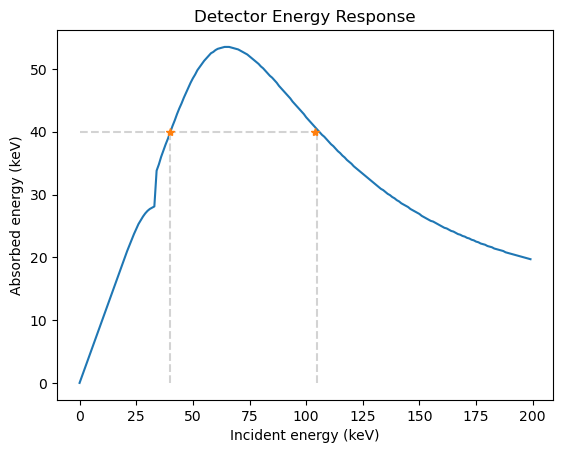

In [7]:
# Read response data
energy_response = np.loadtxt("./input_data/responseDetector.txt")[:200] * 1000

# Plot
fig, ax = plt.subplots()
ax.plot(energy_response[:,0], energy_response[:,1])
ax.set_title("Detector Energy Response")
ax.set_xlabel("Incident energy (keV)")
ax.set_ylabel("Absorbed energy (keV)")

# Guidelines
plt.hlines(40,0,104, linestyle='--', color="lightgray")
plt.vlines((40,105),0,40,linestyles="--", colors="lightgray")
plt.plot((40,104),(40,40), "*")

As seen in the graph above, a received power input of 40keV will result in a 40keV output. However, an input of 104keV will also show 40keV!

Most people are not able to swap out scintillators and compare results, but with simulation we can compare the effects of different response curves, and what we'll get with a perfect detector. Below is some quick code to show how to quickly run a simulation with different energy responses. Using gVXR, we can directly load `responseDetector.txt` by using `gvxr.loadDetectorEnergyResponse()` containing our energy lookup table and apply it to our simulation. This file is in the same format as GATE Monte Carlo simulations.

To make our lives easier, the simulation environment is loaded from a json file. Loading gVXR via configuration files is covered in the next lesson, `06-CT-acquisition`.
In this specific case, we have a model consisting of 5 differently shaped spheres, with different elemental compositions.

![](img/spheres.png)

|Sphere Size| Colour|Element|
| --- | --- | --- |
| Smallest Sphere | <span style="color:blue">Blue</span> | Tungsten |
| Small Sphere | <span style="color:orange">Orange</span> |Titanium |
| Medium Sphere | <span style="color:green">Green</span> |Copper | 
| Large Sphere | <span style="color:red">Red</span> |Carbon |
| Largest Sphere | <span style="color:purple">Purple</span> |Aluminum |

Beam Properties:
- Parallel
- Dual 40 keV & 104keV Beam

Create an OpenGL context: 800x450
Set up the detector
	Detector position: [0, 10, 0, 'cm']
	Detector up vector: [0, 0, -1]
	Number of pixels: [300, 320]
	Detector number of pixels: [300, 320]
	Pixel spacing: [0.3, 0.3, 'mm']
Set up the beam
	Source position: [0, -10, 0, 'cm']
	Source shape: Parallel


Tue Mar  7 17:11:25 2023 ---- Initialise the renderer
Tue Mar  7 17:11:25 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/input_data/phantoms/spheres/spheres-0.stl	nb_faces:	1980	nb_vertices:	5940	bounding_box (in cm):	(-2.84322, -2.84322, -0.043211)	(2.84321, 2.84321, 0.043211)
Tue Mar  7 17:11:25 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/input_data/phantoms/spheres/spheres-1.stl	nb_faces:	1980	nb_vertices:	5940	bounding_box (in cm):	(-2.88643, -2.88643, -0.086422)	(2.88642, 2.88642, 0.086422)
Tue Mar  7 17:11:25 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/input_data/phantoms/spheres/spheres-2.stl	nb_faces:	1980	nb_vertices:	5940	bounding_box (in cm):	(-2.97285, -2.97285, -0.172844)	(2.97284, 2.97284, 0.172844)
Tue Mar  7 17:11:25 2023 ---- file_name:	/home/franck/PROGRAMMING/GitHub/gvxr-tutorials/input_data/phantoms/spheres/spheres-3.stl	nb_faces:	1980	nb_vertices:	5940	bounding_box (in cm):	(-3.14569, -3.14569, -0

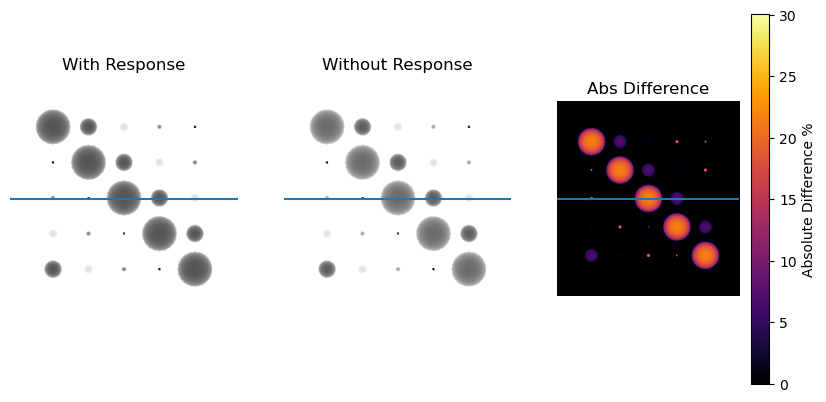

In [8]:
fig, ax = plt.subplots(1,3,sharey=True)
fig.set_figwidth(10)

# Load in gvxr parameters from a json file
gvxr.clearDetectorEnergyResponse()
json2gvxr.initGVXR("./notebook5-multimat-spheres.json", "EGL")
json2gvxr.initDetector()
json2gvxr.initSourceGeometry()
json2gvxr.initSamples()
gvxr.resetBeamSpectrum()
gvxr.addEnergyBinToSpectrum(40,"keV",1)
gvxr.addEnergyBinToSpectrum(104,"keV",1)

# Horizontal line profile
cut = 160

# 40kev & 104kev with response
gvxr.loadDetectorEnergyResponse("./input_data/responseDetector.txt","MeV")
withres = np.asarray(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()
ax[0].set_axis_off()
ax[0].imshow(withres,cmap="gray")
ax[0].set_title("With Response")
ax[0].hlines(cut,0,withres.shape[1]-1)

# 40kev & 104kev without response
gvxr.clearDetectorEnergyResponse()
withoutres = np.asarray(gvxr.computeXRayImage()) / gvxr.getTotalEnergyWithDetectorResponse()
ax[1].set_axis_off()
ax[1].set_title("Without Response")
ax[1].imshow(withoutres,cmap="gray")
ax[1].hlines(cut, 0, withoutres.shape[1]-1)

# Difference
diff = (np.abs(withoutres-withres) / withoutres) * 100
ax[2].set_axis_off()
ax[2].set_title("Abs Difference")
im = ax[2].imshow(diff, cmap="inferno")
plt.colorbar(im, label="Absolute Difference %", ax=ax[2])
ax[2].hlines(cut, 0, diff.shape[1]-1)
gvxr.renderLoop()
plt.show()

As you can see from the absolute difference image, there are definitely changes caused by energy response in our detected readings. By taking a line profile and comparing both energy response, and perfect projections we can have a closer look at what values are changed.

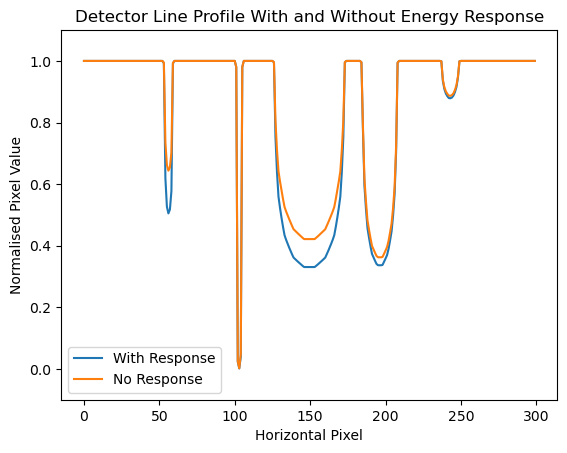

In [9]:
# Difference
fig, ax = plt.subplots()
ax.plot(withres[cut])
ax.plot(withoutres[cut])
ax.set_ybound(0,1)
ax.set_title("Detector Line Profile With and Without Energy Response")
ax.legend(("With Response", "No Response"))
ax.set_ylabel("Normalised Pixel Value")
ax.set_xlabel("Horizontal Pixel")
ax.set_ybound(-0.1,1.1)
plt.show()

These readings indicate that detector response actually over-estimates the received keV value compared to our baseline. This can be seen in the central large aluminum sphere very clearly, resulting in sharper edges with this response curve. This behavior might actually be wanted if you were just comparing contrast and using the scans to detect features, but if using the pixel value to recover a material's mu and composition, the readings will effect your results.

The detector's energy response is something to keep in mind, but is inherent in the scintillator, and is not user configurable. 